# This script demonstrates Large scale text analysis with deep learning

## Name : Eun-Yeong Jeon

## github : https://github.com/Eun0/NLP/tree/master/Yandex

## sources : https://github.com/yandexdataschool/nlp_course/blob/master/week02_classification/seminar.ipynb



# Task :

Predicting job salary by using deep learning

# Outline :

1.

2.

3.

# Import packages for plotting graphs and manipulating data :

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Load data :

kaggle data,

you can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction/data)

if you are first time, remove the comment (#)!

In [2]:
!curl -L https://www.dropbox.com/s/5msc5ix7ndyba10/Train_rev1.csv.tar.gz?dl=1 -o Train_rev1.csv.tar.gz
!tar -xvzf ./Train_rev1.csv.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  119M  100  119M    0     0  32.1M      0  0:00:03  0:00:03 --:--:-- 38.1M
Train_rev1.csv


In [0]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)

# Analyze data :

224768 sample data with 12 features

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244768 entries, 0 to 244767
Data columns (total 12 columns):
Id                    244768 non-null int64
Title                 244767 non-null object
FullDescription       244768 non-null object
LocationRaw           244768 non-null object
LocationNormalized    244768 non-null object
ContractType          65442 non-null object
ContractTime          180863 non-null object
Company               212338 non-null object
Category              244768 non-null object
SalaryRaw             244768 non-null object
SalaryNormalized      244768 non-null int64
SourceName            244767 non-null object
dtypes: int64(2), object(10)
memory usage: 22.4+ MB


## Problem : Oddly distributed

One problem with salary prediction is that it's oddly distributed

The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization

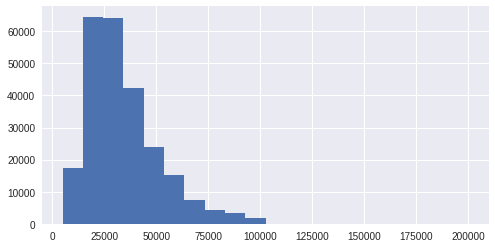

In [5]:
plt.figure(figsize=[8, 4])
plt.hist(data["SalaryNormalized"], bins=20);

There are several techniques to combat this :

1. Using different loss function

2. Predicting log-target instead of raw target

3. Replacing targets with their percentiles among all salaries in the training set

We gonna use __logarithm__ for now

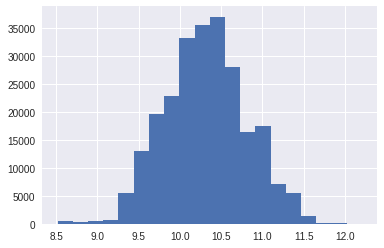

In [6]:
# Add 'Log1pSalary' column

data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.hist(data['Log1pSalary'], bins=20);

Our task is to predict one number,__Log1pSalary__

To do so, our model can access a number of features:

- Free text : __Title__ , __FullDescription__

- Categorical : __Category__, __Company__, __LocationNormalized__, __ContractType__, __ContractTime__


In [0]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"

## Handling null values :

__Title__, __ContractType__, __ContractTime__, __Company__, __SourceName__ columns have null values

Use ```pandas.fillna(replacement)``` to remove null values

In [8]:
data.isnull().sum()

Id                         0
Title                      1
FullDescription            0
LocationRaw                0
LocationNormalized         0
ContractType          179326
ContractTime           63905
Company                32430
Category                   0
SalaryRaw                  0
SalaryNormalized           0
SourceName                 1
Log1pSalary                0
dtype: int64

In [9]:
data['Title']=data['Title'].fillna('')
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.isnull().sum()

Id                    0
Title                 0
FullDescription       0
LocationRaw           0
LocationNormalized    0
ContractType          0
ContractTime          0
Company               0
Category              0
SalaryRaw             0
SalaryNormalized      0
SourceName            1
Log1pSalary           0
dtype: int64

## Show sample data :

In [10]:
data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
184719,71659378,Food And Beverage Manager Operations Live In,Food and Beverage Manager A food and Beverage ...,"Aberdeen, Aberdeenshire, UK, Greater London",London,NaN,NaN,Network Hospitality Recruitment,Hospitality & Catering Jobs,"From 25,000 to 30,000 per annum",27500,jobs.catererandhotelkeeper.com,10.221977
233377,72480923,C I Engineer Berkshire,Atkins is one of the country s leading designe...,Silchester,Silchester,NaN,permanent,Atkins Ltd Defence Aerospace Comms,Other/General Jobs,MIN: 28000 MAX: 35000,31500,jobsite.co.uk,10.357775
205700,72118294,NPD Manufacturing Compliance Officer,"Our client, an expanding Pharmaceutical compan...","West London, London",West London,NaN,permanent,SRG Clinical,Healthcare & Nursing Jobs,25000 - 28000/annum,26500,cv-library.co.uk,10.184937


# Preprocess data part :

Goal of this part is to __make data for use in deep learning__ 

1 . Convert each text columns to (integer) matrix 

2 . Convert each categorical columns by one-hot encoding 

# 1. Preprocessing text data : 

Splitting raw text into sequences of tokens (words, punctuation, etc)

To do this, we need three steps :

1. To lowercase

2. Tokenize

3. Store the tokenized data as a space-separated string of tokens


and Make (integer) matrix by using the vocabulary 

## Show raw text of FullDescription : 

In [11]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


## Define preprocessing(raw_text) function :

Apply above 3 steps to raw_text

In [0]:
## 소문자로 바꾸고 토큰화 under Title,FullDescription
## 결과를 공백으로 구분된 string으로 저장

def preprocessing(raw_text):
    
    # Set tokenizer
    import nltk
    tokenizer = nltk.tokenize.WordPunctTokenizer()
    
    # To lowercase
    result=''.join(list(map(str.lower,raw_text)))
    
    # Tokenize
    result=tokenizer.tokenize(result)
    
    # Store data as a space-separated string of tokens
    return ' '.join(result)

## Preprocessing the raw text :

In [0]:
data['Title']=data['Title'].map(lambda x : preprocessing(x))

In [0]:
data['FullDescription']=data['FullDescription'].map(lambda x : preprocessing(x))

## Show the result : 

In [15]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'
assert data["Title"][54321] == 'international digital account manager ( german )'

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


# Make word-count vocabulary :

we will use __Counter__ (in collections packages) to make vocabulary

The usage of Counter is as follows

Counter returns like dictionary

In [16]:
from collections import Counter

lines=['hi how are you','i am fine thank you']

# Split and flatten
# why flatten?
# if no flatten because split() returns list
# , so the result would be list of list

res=[y for line in lines for y in line.split()]
print(res)

print(Counter(res))

['hi', 'how', 'are', 'you', 'i', 'am', 'fine', 'thank', 'you']
Counter({'you': 2, 'hi': 1, 'how': 1, 'are': 1, 'i': 1, 'am': 1, 'fine': 1, 'thank': 1})


## Concatenate 'Title' and 'FullDescription' columns :

Is it okay?

we'll only count the words,so it's okay to concatenate

<br>

__\* CAUTION \*__

Because we handle space-separated string of tokens,

we have to __insert ' '(blank space)__ in the middle of two cols when using '+' operator

In [17]:
# example
a=pd.DataFrame({'a':['hi','nice'],'b':['what','the']})
b=pd.DataFrame({'a':['why','so'],'b':['fuck','me']})

print(a+b)
print(a+" "+b)

        a         b
0   hiwhy  whatfuck
1  niceso     theme
         a          b
0   hi why  what fuck
1  nice so     the me


## Build word-count vocabulary : 

In [0]:
## Concatenate two columns
title_and_fullD=data['Title']+" "+data['FullDescription']

## Split and flatten for Counting
tokens=[y for line in title_and_fullD for y in line.split()]

## Make word-count voca
token_counts=Counter(tokens)

## Show the result :

In [19]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


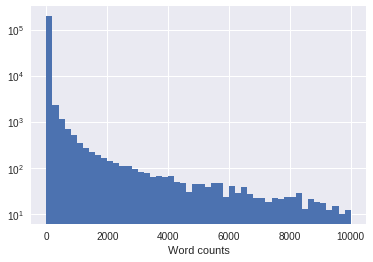

In [20]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

## Remove infrequent tokens :

Filter tokens a list of all tokens that occur at least 10 times

In [0]:
min_count = 10

## tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [token for token in token_counts if token_counts[token]>=min_count]

In [22]:
# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + sorted(tokens)
print("Vocabulary size:", len(tokens))

assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 34158
Correct!


## Build an inverse token index :

A dictionary from token to it's index(int) in tokens

In [0]:
## My Code
token_to_id={}

for token in tokens:
    
    token_to_id[token]=tokens.index(token)

In [24]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


## Make neural network-digestible matrices by using vocabulary we've built :

Map text line into integer (padding if necessary)



In [0]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
    
    # seq의 최대 길이 구하고
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    # 맨 처음 패드의 index값으로 채우고
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        # 단어 길이만큼 matrix row에 할당
        # 사전에 없는 단어는 UNK의 index값으로 채움
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

## Example

Sequences :

line 1 ) engineering systems analyst

line 2 ) hr assistant

line 3 ) senior ec & i engineer

<br>

maximum length of sequences = 5 (line 3)

so matrix : 3 x 5 mat

<br>

the length of line 1 is 3 

so 3 will be filled with index values for the word, 2 will be padded 






In [26]:
print("UNK의 index:",UNK_IX)
print("PAD의 index:",PAD_IX,"\n")
# example
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

UNK의 index: 0
PAD의 index: 1 

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[10807 30161  2166     1     1]
 [15020  2844     1     1     1]
 [27645 10201    16 15215 10804]]


## 2. One-hot encoding for categorical columns :

Example , For 'Company' col

In [27]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
        sparse=False)

# The deep learning part

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous__, we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [28]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [0]:
def make_batch(data, max_len=None, word_dropout=0):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [30]:
make_batch(data_train[:3], max_len=10)

{'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'FullDescription': array([[27645, 29893, 33674, 32939,   982, 27645, 29893, 33674, 16451,
         32939],
        [29239,   197, 19175, 20042, 15554, 23162,  4051, 25511,   907,
            82],
        [30746, 21956, 20601,  6409, 16451,  8165, 27493,   982, 30412,
         17746]], dtype=int32),
 'Log1pSalary': array([ 9.71154 , 10.463132, 10.71444 ], dtype=float32),
 'Title': array([[27645, 29893, 33674,     1,     1,     1,     1],
        [29239,   197, 19175, 20042, 15554, 23162,  4051],
        [10609, 30412, 17746,    33,  8705, 29157,    65]], dtype=int32)}

# Architecture

- Title encoder

- Description encoder

- Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

This clearly doesn't fit into keras' __Sequential__ interface. To build such a network, one will have to use Keras Functional API.

## Import packages for construction of model :

In [31]:
import keras
import keras.layers as L

Using TensorFlow backend.


In [0]:
def build_model(n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
    """ Build a model that maps three data sources to a single linear output: predicted log1p(salary) """
    
    l_title = L.Input(shape=[None], name="Title")
    l_descr = L.Input(shape=[None], name="FullDescription")
    l_categ = L.Input(shape=[n_cat_features], name="Categorical")
    
    ## Build your monster!
    
    emb=L.Embedding(n_tokens,hid_size)
    
    l_title_emb=emb(l_title)
    l_title_conv=L.Conv1D(hid_size,2,activation='relu')(l_title_emb)
    output_title=L.GlobalMaxPooling1D()(l_title_conv)

    
    l_descr_emb=emb(l_descr)
    l_descr_conv=L.Conv1D(hid_size,3,activation='relu')(l_descr_emb)
    output_descr=L.GlobalMaxPool1D()(l_descr_conv)
    
    output_categ=L.Dense(hid_size)(l_categ)
    
    l_combined=L.Concatenate()([output_title,output_descr,output_categ])
    l_combined_dense=L.Dense(2*hid_size,activation='relu')(l_combined)
    
    output_layer=L.Dense(1)(l_combined_dense)
    
    '''
    hidden1=L.Embedding(n_tokens,hid_size)(l_title)
    hidden1=L.Conv1D(hid_size,2,activation='relu')(hidden1)
    output_title=L.GlobalMaxPooling1D()(hidden1)

    
    hidden2=L.Embedding(n_tokens,hid_size)(l_descr)
    hidden2=L.Conv1D(hid_size,2,activation='relu')(hidden2)
    output_descr=L.GlobalMaxPool1D()(hidden2)
    
    output_categ=L.Dense(hid_size)(l_categ)
    
   
    concatenate=L.Concatenate()([output_title,output_descr,output_categ])
    l_concatenate=L.Dense(2*hid_size,activation='relu')(concatenate)
    
    output_layer = L.Dense(1)(l_concatenate)
    #output_layer=L.concatenate([output_title,output_descr,output_categ])
    # end of your code
    '''
    model = keras.models.Model(inputs=[l_title, l_descr, l_categ], outputs=[output_layer])
    model.compile('adam', 'mean_squared_error', metrics=['mean_absolute_error'])
    
    return model

In [56]:
model = build_model()
model.summary()

dummy_pred = model.predict(make_batch(data_train[:100]))
dummy_loss = model.train_on_batch(make_batch(data_train[:100]), data_train['Log1pSalary'][:100])[0]
assert dummy_pred.shape == (100, 1)
assert len(np.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert np.ndim(dummy_loss) == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Title (InputLayer)              (None, None)         0                                            
__________________________________________________________________________________________________
FullDescription (InputLayer)    (None, None)         0                                            
__________________________________________________________________________________________________
embedding_17 (Embedding)        (None, None, 64)     2186112     Title[0][0]                      
                                                                 FullDescription[0][0]            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, None, 64)     8256        embedding_17[0][0]               
__________

In [0]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            target = batch.pop(target_column)
            yield batch, target
        
        if not cycle: break

In [58]:
batch_size = 256
epochs = 10            # definitely too small
steps_per_epoch = 100  # for full pass over data: (len(data_train) - 1) // batch_size + 1

model = build_model()

model.fit_generator(iterate_minibatches(data_train, batch_size, cycle=True, word_dropout=0.05), 
                    epochs=epochs, steps_per_epoch=steps_per_epoch,
                    
                    validation_data=iterate_minibatches(data_val, batch_size, cycle=True),
                    validation_steps=data_val.shape[0] // batch_size
                   )

Epoch 1/10
100/100 [==============================] - 126s 1s/step - loss: 18.6301 - mean_absolute_error: 2.7015 - val_loss: 0.2750 - val_mean_absolute_error: 0.4131
Epoch 2/10
100/100 [==============================] - 120s 1s/step - loss: 0.2188 - mean_absolute_error: 0.3623 - val_loss: 0.1852 - val_mean_absolute_error: 0.3300
Epoch 3/10
100/100 [==============================] - 120s 1s/step - loss: 0.1601 - mean_absolute_error: 0.3062 - val_loss: 0.1500 - val_mean_absolute_error: 0.2947
Epoch 4/10
100/100 [==============================] - 119s 1s/step - loss: 0.1374 - mean_absolute_error: 0.2807 - val_loss: 0.1335 - val_mean_absolute_error: 0.2767
Epoch 5/10
100/100 [==============================] - 120s 1s/step - loss: 0.1213 - mean_absolute_error: 0.2629 - val_loss: 0.1157 - val_mean_absolute_error: 0.2570
Epoch 6/10
100/100 [==============================] - 121s 1s/step - loss: 0.1102 - mean_absolute_error: 0.2508 - val_loss: 0.1111 - val_mean_absolute_error: 0.2512
Epoch 7/1

In [59]:
def print_metrics(model, data, batch_size=batch_size, name="", **kw):
    squared_error = abs_error = num_samples = 0.0
    for batch_x, batch_y in iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw):
        batch_pred = model.predict(batch_x)[:, 0]
        squared_error += np.sum(np.square(batch_pred - batch_y))
        abs_error += np.sum(np.abs(batch_pred - batch_y))
        num_samples += len(batch_y)
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % (squared_error / num_samples))
    print("Mean absolute error: %.5f" % (abs_error / num_samples))
    return squared_error, abs_error
    
print_metrics(model, data_train, name='Train')
print_metrics(model, data_val, name='Val');

Train results:
Mean square error: 0.07875
Mean absolute error: 0.20874
Val results:
Mean square error: 0.08866
Mean absolute error: 0.22277


In [0]:
def explain(model, sample, col_name='Title'):
    """ Computes the effect each word had on model predictions """
    sample = dict(sample)
    sample_col_tokens = [tokens[token_to_id.get(tok, 0)] for tok in sample[col_name].split()]
    data_drop_one_token = pd.DataFrame([sample] * (len(sample_col_tokens) + 1))

    for drop_i in range(len(sample_col_tokens)):
        data_drop_one_token.loc[drop_i, col_name] = ' '.join(UNK if i == drop_i else tok
                                                   for i, tok in enumerate(sample_col_tokens)) 

    *predictions_drop_one_token, baseline_pred = model.predict(make_batch(data_drop_one_token))[:, 0]
    diffs = baseline_pred - predictions_drop_one_token
    return list(zip(sample_col_tokens, diffs))

In [0]:
from IPython.display import HTML, display_html

def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):
    
    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(weight)), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]
    
    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]
    
    
    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))
        
    return raw_html

In [62]:
i = 36605
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

sales specialist iv access and infusion

sales representative medical sales iv access and infusion an opportunity to work for the industry leading manufacturer of iv access and infusion solutions . formally recognised as the number **** company in this market space , our client are an ethical and dynamic organisation absolutely committed to the advancement of innovative technologies . job title : sales specialist iv access and infusion selling : medication delivery solutions selling to : iv teams , infection control , lead intensive care nurse specialists , ward managers territory : east midlands location : east midlands package : basic : **** k **** k , uncapped bonus in addition , full corporate benefits company information hugely ethical and professional global organisation extremely well established in the uk the market leader across all of their core business areas focus on providing cutting edge solutions along with outstanding service and support a business that retain talented personnel by offering a strong platform for career development sales specialist iv access and infusion you must have / be the following at least 2 years medical device sales experience . candidates who have sold disposables / consumables or similar into hospitals would be of particular interest . candidates must have sold into hospitals demonstrable performance and achievements so far personable , adaptable and willing to learn keen and eager to be a success candidates must have a degree or at least be able to show a strong ability to learn role information managing the east midlands region selling across the company ' s range of iv and infusion solutions portfolio selling into lead intensive care nurse specialists , ward managers , iv teams , infection control teams , procurement sales specialist iv access and infusion candidates must be eligible to work and live in the uk . please contact allan waller on **** **** **** or please hit the apply button . this job was originally posted as www . salestarget . co . uk / jobseeking / UNK ****

In [63]:
i = 12077
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

cleaning operative

12 . 5 hours per week monday friday 9am 11 . 30am duties to include sweeping , mopping , vacuuming , buffing , cleaning staff toilets and rest room . must be able to read as they will be using UNK which need UNK as per instructions on the containers . sucessfull applicants will be trained on all electrical appliances and UNK of cleaning materials .

In [64]:
i = np.random.randint(len(data))
print("Index:", i)
print("Salary (gbp):", np.expm1(model.predict(make_batch(data.iloc[i: i+1]))[0, 0]))

tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

Index: 159126
Salary (gbp): 6501.6646


year 4 teacher needed in highbury and islington from april 2013

year 4 teacher highbury and islington april 20 **** 3 a lovely school based in highbury and islington are looking for a creative and motivated year 4 teacher . this maternity role will start from april 2013 until the rest of the school year . the position requires a confident teacher who is willing to share their skills and experience with other members of the team . the successful year 4 teacher will be working at this wonderful 1 form entry school , where children come from diversity backgrounds . in their most recent ofsted report they have been awarded ' outstanding '. they have talented staff dedicated to teaching all pupils to the highest standards . to apply for this role , you will need to meet the following criteria : eligible to work in the uk pgce , bachelor of education or hold an equivalent qualification from abroad qts crb , valid references and police checks please contact UNK at np education to apply . np education works in partnership with schools and academies throughout the uk to support the recruitment process for daytoday , shortterm and longterm cover , and permanent contracts . from newly qualified teachers to head teachers , we recruit across all phases of the education sector . np education is part of itn mark education , the leading education recruitment specialist with 22 offices across the uk . itn mark education is an equal opportunities employer . itn mark education is acting as an employment business in relation to this vacancy .